In [1]:
import os
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm_notebook as tqdm
from matplotlib import rc
rc('text', usetex=True)


def load_results(name):
  A = np.load(name)
  B = pd.DataFrame(A.transpose())
  B = B.rename({0:"q",1:"Raoult",2:"Dandies",3:'Conformists',4:"Informed",5:"c",6:"Ω",7:"Prop_i",8:"Herding",9:"Cyclicity",10:"Max_in_deg",11:"alpha",12:"p"},axis=1)
  return B

from curtymarsili_class import CurtyMarsili



In [3]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6,4))
gs = gridspec.GridSpec(2,2,figure=fig)


CM = pickle.load(open("./Objects_to_plot/Fig_2.pl","rb"))
ax1 = fig.add_subplot(2,1,2)
color="green"
color2='red'
ax1.set_xlabel('Time')
plt.yticks([0,.02,.05,.08])
ax1.plot(pd.DataFrame(CM.prop_i).rolling(10000).mean(),color="black")
ax2 = ax1.twinx()
#ax2.set_ylabel('q',color="red")
ax2.plot(pd.DataFrame(CM.q_history).rolling(10000).mean(),color='red',label="$q$")
ax2.plot(np.nan,np.nan,color="black",label="$s$")
ax2.tick_params(axis='y',color="red")
ax2.legend()
plt.yticks(color="red")
plt.title("(b)")


ax = fig.add_subplot(gs[0,0])
CM = pickle.load(open("./Objects_to_plot/fig2b.pl","rb"))
ax.hist(CM.accuracy[CM.follower],density=True,alpha=.6,label="Informed")
ax.hist(CM.accuracy[~CM.follower],density=True,alpha=.6,label="Lazies")
ax.set_xlabel("Scores")
ax.legend()
plt.title("(a)")

ax = fig.add_subplot(gs[0,1])
def plot_loghist(x, bins=30,cumulative=False):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    ax.hist(x, bins=logbins,log=True,density=True,cumulative=cumulative,color='grey')
    plt.xscale('log')
in_deg = np.load("./Objects_to_plot/zipf.npy")
z = in_deg>0
plot_loghist(in_deg[z],bins=30,cumulative=-1)
X = np.exp(np.linspace(0,np.log(max(in_deg)),1000))
ax.plot(X,[1/(x**.75) for x in X],label="$y= x^{-\\mu}$",color='black')
plt.title("(c)")
plt.tight_layout()
ax.legend()
plt.savefig("tryptic.png",dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: './Objects_to_plot/Fig_2.pl'

<Figure size 432x288 with 0 Axes>

<ipython-input-3-ea37d12fb974>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  b = [analytical_q(z) for z in tqdm(reversed(zs))]


<ipython-input-3-ea37d12fb974>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(zzs))):


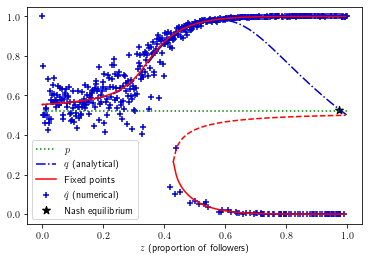

In [3]:
import pickle
from scipy.special import binom
import scipy.optimize as opt
from scipy.special import erfc
zs = np.linspace(0,1,500, endpoint=False)
qs = pickle.load(open("./Objects_to_plot/MC.pl","rb"))

def analytical_q(z,m = 11,N = 2000,p = 0.52):
    def F(q):
        pi = (1-z) * p + z*q
        return np.sum([binom(m, l)* pi**l * (1-pi) ** (m-l) for l in range((m+1)//2, m+1)]) - q

    q_ = opt.root(F,x0=0).x # Find the lower fixed point
    q = opt.root(F,x0=1).x # Find the upper one
    if(F(q-0.05)*F(q_+0.05)<0): # if they're of the same sign, then we have not yet passed the critical point
        qu = opt.brentq(F, q_+0.05, q-0.05) # Find the unstable one, between the two
        p_ = erfc(np.sqrt(N*z/2)*(1-2*qu))/2 # Compute the probability of being initialized below the unstable one
        q = p_ * q_ + (1 - p_)*q
    return q

b = [analytical_q(z) for z in tqdm(reversed(zs))]

plt.figure(num=None, figsize= (6,4))
plt.plot(zs[::-1],.52*np.ones(zs.size),':',label="$p$",color="green")
plt.plot(zs[::-1],b,'-.',color='mediumblue',label="$q$ (analytical)")
plt.scatter(zs[::-1],qs,label='$\hat{q}$ (numerical)',color='mediumblue',marker='+')



plt.xlabel("$z$ (proportion of followers)")

def fixed_point(z,p,m, n_its = 1000):
    def F_z(q):
        pi = z * p + (1-z)*q
        F_z = np.sum([binom(m, l)* pi**l * (1-pi) ** (m-l) for l in range((m+1)//2, m+1)])
        return F_z
    
    q_0 = 0 
    q_1 = 1
    q_mid = 0.5
    for i in range(n_its):
        q_0 = F_z(q_0)
        q_1 = F_z(q_1)
    q_mid = opt.brentq(lambda q: F_z(q)-q, (q_0+0.05), (q_1-0.05))
    return q_0, q_1, q_mid
zzs = np.linspace(0,1,200, endpoint=False)
lower = np.empty(len(zzs))
upper = np.empty(len(zzs))
mid = np.empty(len(zzs))

for i in tqdm(range(len(zzs))):
    lower[i], upper[i], mid[i] = fixed_point(zzs[i], p =0.52, m =11)
mid[::-1][86] = (lower[::-1][87]+ mid[::-1][87])/2
lower[::-1][86] = (lower[::-1][87]+ mid[::-1][87])/2
plt.plot(zzs, upper[::-1], color='red',label='Fixed points')
plt.plot(zzs[86:], lower[::-1][86:], color='red')
plt.plot(zzs[86:], mid[::-1][86:],"--", color='red')
plt.scatter([.975],[.525],marker="*",s=70,color="black",label="Nash equilibrium")

plt.legend()
plt.savefig("./MC.png",dpi=300)

<Figure size 432x288 with 0 Axes>

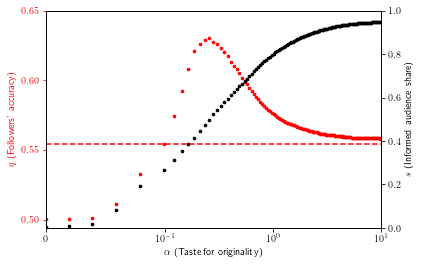

In [17]:
B = load_results('./Objects_to_plot/results_fig4.npy')
fig = plt.figure(figsize=(6,4))
fig, ax1 = plt.subplots()
color2="black"
color='red'
ax1.set_xlabel("$\\alpha$ (Taste for originality)")
ax1.set_ylabel("$q$ (Followers' accuracy)",c=color)

ax1.scatter(B.alpha,B.q,s=7,color=color)
ax1.plot([0,10],[0.55399653,0.55399653],"--",color=color)
plt.yticks([.5,.55,.6,.65],color=color)
ax1.tick_params(axis='y',color=color)
ax2 = ax1.twinx()
ax2.set_ylabel('$s$ (Informed audience share)',color=color2)
ax2.scatter(B.alpha,B.Prop_i,color=color2,s=7)
plt.ylim((0,1))
ax2.tick_params(axis='y',color=color2)
plt.yticks([0,0.2,0.4,0.6,0.8,1],color=color2)
plt.xscale("symlog",linthresh=.1)
plt.xlim((0,10))
plt.savefig("./Fig4.png",dpi=300)

<Figure size 432x288 with 0 Axes>

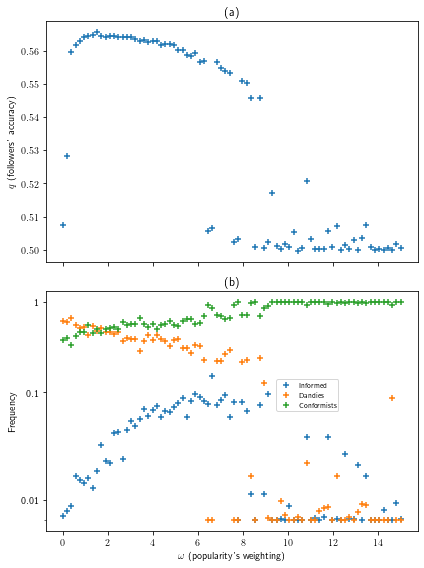

In [18]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6,4))
fig,axs = plt.subplots(2,1,figsize=(6,8))

B = load_results("./Objects_to_plot/fig6.npy")
C = B[B.p==.52]
axs[0].scatter(C.Ω,C.q,marker="+")

axs[0].set_ylabel("$q$ (followers' accuracy)")
#plt.savefig("Fig6.png",dpi=300)

axs[1].scatter(C.Ω,C.Informed+.0,label="Informed",marker="+")
axs[0].set_title("(a)")

plt.setp(axs[0].get_xticklabels(), visible=False) 

axs[1].set_title("(b)")
axs[1].scatter(C.Ω,C.Dandies+.0,label="Dandies",marker="+")
axs[1].scatter(C.Ω,C.Conformists+.0,label="Conformists",marker="+")


plt.yscale('symlog',linthresh = .5*10**-1)
plt.xlabel("$\\omega$ (popularity's weighting)")
plt.ylabel("Frequency")
plt.legend(loc=(.62,.5),prop={'size': 7})
plt.yticks([.01,.1,1],[.01,.1,1])
plt.tight_layout()
plt.savefig("Types.png",dpi=300)

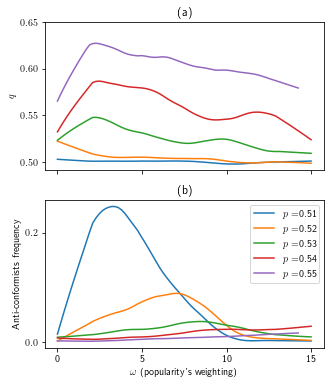

In [9]:
fig,axs = plt.subplots(2,1,figsize=(5,6))


B = load_results("./Objects_to_plot/results.npy")
P = np.unique(B.p)
P = P[:5]
for p in P:
    C = B[B.p == p]
    A = pd.DataFrame({"Ω":C.Ω,"q":(C.q)}).sort_values(by="Ω")
    axs[0].plot(A.Ω,lowess(A.q,A.Ω,return_sorted=False,frac=.3),label="p = "+str(np.round(p,2)))
    #axs[0].scatter(C.Ω,(C.q),s=10,marker="+")


plt.xlabel("$$\omega$$ (popularity's weighting)")
plt.xticks([0,5,10,15],[0,5,10,15])

axs[0].set_ylabel("$q$")

plt.setp(axs[0], xticks=[0,5,10,15],
        yticks=[.50,.55,.60,.65])
plt.setp(axs[0].get_xticklabels(), visible=False) 
plt.setp(axs[1], xticks=[0,5,10,15],
        yticks=[0,.2,.4])

for p in P:
    C = B[B.p == p]
    A = pd.DataFrame({"Ω":C.Ω,"q":C.Raoult}).sort_values(by="Ω")
    axs[1].plot(A.Ω,lowess(A.q,A.Ω,return_sorted=False,frac=.3),label="$p = $"+str(np.round(p,2)))
    #axs[1].scatter(C.Ω,C.Raoult,s=10,marker="+") # remove the # to plot the dots

axs[0].set_title("(a)")
axs[1].set_title("(b)")
plt.legend()
plt.xlabel("$\\omega$ (popularity's weighting)")
plt.ylabel("Anti-conformists frequency")


plt.savefig("./q_raoult.png",dpi=300)

<ipython-input-33-897138837af1>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for z in tqdm(x):


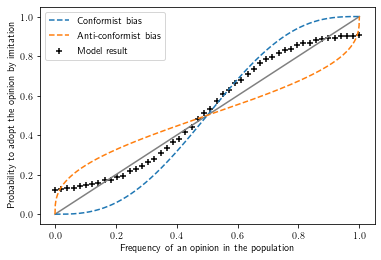

In [33]:
from scipy.special import binom
! pip3 install pynverse
from pynverse import inversefunc
def f(pi):
    return (1-z)*p +z*np.sum([binom(m, l)* pi**l * (1-pi) ** (m-l) for l in range((m+1)//2, m+1)])
plt.figure(num=None, figsize= (6,4))
z=1
R = []
CM = pickle.load(open("./Objects_to_plot/fig1.pl","rb"))
x = np.linspace(0,1,50)
for z in tqdm(x):
    A = []
    for i in range(2000):
        CM.D[CM.follower] = np.random.choice([-1,1],p = [1-z,z],size = CM.follower.sum())
        CM.D[~CM.follower] = np.random.choice([-1,1],p = [1-CM.p,CM.p],size = CM.N - CM.follower.sum())
        CM.D[CM.follower] = np.sign(CM.D[CM.network[CM.follower,]].sum(axis=1))
        A.append(CM.compute_q())
    R.append(np.mean(A))
        
plt.scatter(x,R,marker="+",color="black",label="Model result")
plt.plot(x,x,color="grey")
X = np.linspace(0,1,1000)
p=.5
m=5
plt.plot(X,[[(1-z)*p +z*np.sum([binom(m, l)* pi**l * (1-pi) ** (m-l) for l in range((m+1)//2, m+1)])] for pi in X],label="Conformist bias",linestyle='dashed')
plt.plot(X,[inversefunc(f,y_values=x) for x in X],label="Anti-conformist bias",linestyle='dashed')

plt.xlabel("Frequency of an opinion in the population")
plt.ylabel("Probability to adopt the opinion by imitation")
plt.legend()
plt.savefig("Bias.png",dpi=300)